### custom FFNN
#### 2) 여러개의 layer가 있는 FFNN
이제 여러개의 layer가 있는 FFNN을 고려해보자.
$$\begin{aligned}
s_1 &= x \cdot w_1 + b_1,  &(b, h_1^1=2)\\
h_1 &= f_1(s_1), &(b, h_1^1) \\
s_2 &= h_1 \cdot w_2 + b_2,  &(b, h_2^1=3) \\
h_2 &= f_2(s_2),  &(b, h_2^1) \\
s_3 &= h_2 \cdot w_3 + b_3,  &(b, h_3^1 = 1) \\
\hat y &= f(s_3),  &(b, 1) \\
e &= \sum_i (\hat y - y)^2, &(1, ) \\
& \\
\cfrac {\partial e}{\partial w_3} &= \cfrac{\partial e}{\partial \hat y} \cfrac{\partial \hat y}{\partial s_3} \cfrac{\partial s_3}{\partial w_3}, &(h_2^1, h_3^1=1) \\
&= h_2^T \cdot \left[ 2(\hat y - y) \times f^{'}(s_3) \right]\\
(h_2^1, h_3^1=1) &= (b, h_2^1)^T \cdot [(b, 1) \times (b, 1)]\\
& \\
\cfrac {\partial e}{\partial h_2} &= \cfrac{\partial e}{\partial \hat y} \cfrac{\partial \hat y}{\partial s_3} \cfrac{\partial s_3}{\partial h_2}, &(b, h_2^1) \\
&= \left[ 2(\hat y - y) \times f^{'}(s_3) \right] \cdot w_3 \\
(b, h_2^1) &= [(b, 1) \times (b, 1)] \cdot (h_3^1=1, h_2^1)\\
& \\
\cfrac {\partial e}{\partial w_2} &= \cfrac {\partial e}{\partial h_2} \cfrac{\partial h_2}{\partial s_2} \cfrac{\partial s_2}{\partial w_2}, &(h_1^1, h_2^1) \\
&= h_1^T \cdot \left[ \cfrac {\partial e}{\partial h_2} \times f_2^{'}(s_2) \right]\\
(h_1^1, h_2^1) &= (b, h_1^1)^T \cdot [(b, h_2^1) \times (b, h_2^1)]\\
& \\
\text{for b, }& \text{ We assume } b \cdot x_0, \text{ and } x_0 = \text{np.zeros(h.shape[-1])} \\
\cfrac {\partial e}{\partial b_2} &= \cfrac {\partial e}{\partial h_2} \cfrac{\partial h_2}{\partial s_2} \cfrac{\partial s_2}{\partial b_2}, &(h_2^1,) \\
&= \sum_b \left[ \cfrac {\partial e}{\partial h_2} \times f_2^{'}(s_2) \right]\\
(h_2^1,) &= (b,)^T \cdot [(b, h_2^1) \times (b, h_2^1)]
\end{aligned}$$

따라서 일반화를 하면:
$$\begin{aligned}
\cfrac {\partial e}{\partial w_i} &= \cfrac {\partial e}{\partial h_i} \cfrac{\partial h_i}{\partial s_i} \cfrac{\partial s_i}{\partial w_i}, &(h_{i-1}^1, h_i^1) \\
&= h_{i-1}^T \cdot \left[ \cfrac {\partial e}{\partial h_i} \times f_i^{'}(s_i) \right]\\
(h_{i-1}^1, h_i^1) &= (b, h_{i-1}^1)^T \cdot [(b, h_i^1) \times (b, h_i^1)]\\
& \\
\cfrac {\partial e}{\partial h_i} &= \cfrac{\partial e}{\partial h_{i+1}} \cfrac{\partial h_{i+1}}{\partial s_{i+1}} \cfrac{\partial s_{i+1}}{\partial h_i}, &(b, h_2^1) \\
&= \left[ \cfrac{\partial e}{\partial h_{i+1}}  \times f^{'}(s_{i+1}) \right] \cdot w_{i+1}^T \\
(b, h_i^1) &= [(b, h_{i+1}^1) \times (b, h_{i+1}^1)] \cdot (h_{i+1}^1, h_i^1)\\
& \\
\cfrac {\partial e}{\partial b_i} &= \cfrac {\partial e}{\partial h_i} \cfrac{\partial h_i}{\partial s_i} \cfrac{\partial s_i}{\partial b_i}, &(h_i^1, ) \\
&= \sum_b \left[ \cfrac {\partial e}{\partial h_i} \times f_i^{'}(s_i) \right]\\
(h_i^1,) &= (b,)^T \cdot [(b, h_i^1) \times (b, h_i^1)]
\end{aligned}$$
- $b_i$를 구할 때, np.sum(arr, axis=-1)을 사용하면 된다.
- 아래 첨자가 없는 b는 batch size를 의미한다.

이를 위해 propagate_forward(self, x)함수를 구해보자.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
x_train = np.random.rand(1024,2)
y_train = np.array( [ [3 * x[0] - 1.2 * x[1] + .5] for x in x_train ] )

x_val = np.random.rand(32,2)
y_val = np.array( [ [3 * x[0] - 1.2 * x[1] + .5] for x in x_val ] )

x_test = np.array( [ [0.2, 0.1], [0.3, 0.1], [0.4, 0.1], [0.5, 0.1] ] )
y_test = np.array( [ [3 * x[0] - 1.2 * x[1] + .5] for x in x_test ])

In [3]:
x_train.shape

(1024, 2)

In [4]:
y_train.shape

(1024, 1)

다양한 activation 함수 구현:
$$\begin{aligned}
\text{Linear}(x) &= x\\
\cfrac {\partial \text{Linear}(x)}{\partial x} &= 1\\
\text{Sigmoid}(x) &= \sigma (x) = \cfrac {1}{1-\exp(-x)}\\
\cfrac {\partial \text{Sigmoid}(x)}{\partial x} &= \sigma(x) * (1-\sigma(x))\\
\text{tahn}(x) &= \cfrac {\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}\\
\cfrac {\partial \text{tahn}(x)}{\partial x} &= 1-\text{tahn}^2(x)
\end{aligned}$$

In [5]:
def linear(x): # linear y = x
    return x

def linear_deriv(x): # derivative of y = x
    return 1

def sigmoid(x): # sigmoid
    return 1. / (1 + np.exp(-x))

def sigmoid_deriv(x): # derivative of sigmoid
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x): # hyperbolicv tangent
    return np.tanh(x)

def tanh_deriv(x): # derivative of hyperbolic tangent
    return 1 - np.tanh(x) ** 2

이를 위해 multi layer를 구현할 수 있도록 다음과 같은 절차에 따라 작성한다.

1. layer를 추가할 수 있는 add 함수를 구현한다.
 - 인자로, output의 size인 units와 activation, activation_deriv를 갖는다.
 - 첫 layer는 반드시 input_dim을 지정해야 하며, 이후는 추론한다.

In [6]:
class FFNN:
    
    def __init__(self, lr=0.1):
        self.lr = lr # learning rate
        # weights list
        self.ws = []; self.bs = []
        self.fs = []; self.f_derivs = []
        self.nLayers = 0
        
    # layer를 추가하며, weights를 초기화하기
    def add(self, units, activation=linear, activation_deriv=linear_deriv, 
            input_dim=None):
        if input_dim == None:
            if self.nLayers == 0:
                raise ValueError
            else:
                input_dim = self.bs[-1].shape[0]
        w = np.random.rand(input_dim, units) - .5
        self.ws.append(w)
        b = np.zeros(units)
        self.bs.append(b)
        self.fs.append(activation)
        self.f_derivs.append(activation_deriv)
        self.nLayers += 1
        
    # feed forwarding
    def propagate_forward(self, x):
        s = []; o=[]
        for l in range(self.nLayers):
            if l == 0:
                z = x.dot(self.ws[l]) + self.bs[l]
            else: 
                z = o[l-1].dot(self.ws[l]) + self.bs[l]
            s.append(z)
            o.append(self.fs[l](z))
        return s, o

    # predicting
    def predict(self, x):
        s, o = self.propagate_forward(x)
        return o[-1] # output from the last layer

    # train for one batch. x 자체가 batch
    def train_on_batch(self, x, y, istrain=True):
        # batch forward propagation
        s, o = self.propagate_forward(x)
        loss = 1/2 * np.sum((o[-1] - y)**2)
        
        # batch back propagatgion
        if istrain:
            nL = self.nLayers
            dws = [0.] * nL; dbs = [0.] * nL; dos = [0.] * nL
            N = x.shape[0]
            
            # for nL-1 last layer
            dos[-1] = (o[-1] - y)
            if nL == 1: 
                dws[-1] = x.T.dot(dos[-1] * self.f_derivs[-1](s[-1]))
            else: 
                dws[-1] = o[-2].T.dot(dos[-1] * self.f_derivs[-1](s[-1]))
            dbs[-1] = np.sum(dos[-1] * self.f_derivs[-1](s[-1]))
            
            if nL > 1:
                for l in range(nL-2, -1, -1):
                    dos[l] = (dos[l+1]*self.f_derivs[l+1](s[l+1])).dot(self.ws[l+1].T)
                    if l == 0: dws[l] = x.T.dot(dos[l] * self.f_derivs[l](s[l]))
                    else: dws[l] = o[l-1].T.dot(dos[l] * self.f_derivs[l](s[l]))
                    dbs[l] = np.sum(dos[l] * self.f_derivs[l](s[l]))
            
            for l in range(nL-1, -1, -1):
                dws[l] /= N; dbs[l] /= N
                self.ws[l] -= self.lr * dws[l]; self.bs[l] -= self.lr * dbs[l]
                
        return loss

    # epochs에 대해 batch 별로 학습하기
    def fit(self, x, y, batch_size=16, epochs=5000, val_data=None):
        Losses = {}
        Losses["train_loss"] = []
        if val_data is not None:
            Losses["val_loss"] = []
        
        for i in range(epochs):
            Loss = 0
            N = x.shape[0]
            for j in range(0, N, batch_size):
                x_batch = x[j:j+batch_size]
                y_batch = y[j:j+batch_size]
                n = x_batch.shape[0]
                Loss += (self.train_on_batch(x_batch, y_batch) / n)
        
            print("Train Loss at Epoch %d is %.8f" %(i, Loss))
            Losses["train_loss"].append(Loss)
            if val_data is not None:
                val_N = val_data[0].shape[0]
                val_loss = self.train_on_batch(*val_data, istrain=False) / val_N
                print("Val Loss at Epoch %d is %.8f" %(i, val_loss))
                Losses["val_loss"].append(val_loss)
                
        return Losses

참고로:
- $h_0 = x$, $s_0 = x$, $f_0 = \text{linear}$
- $s_i = h_{i-1} \cdot w_{i-1} + b_{i-1}$
- $h_i = f_i(s_i)$ 로, 설정하면 코딩이 훨씬 쉬웠을 것이다.

----
2 > 3 > 3 > 1 layer를 갖는 FFNN의 인스턴스를 생성한다.
- 출력 2개의 선형 활성함수를 갖는 첫 hidden layer 추가
- 출력 3개의 sigmoid 활성함수를 갖는 둘째 hidden layer 추가
- 출력 3개의 tanh 활성함수를 갖는 셋째 hidden layer 추가
- 출력 1개의 선형 활성함수를 갖는 출력 layer 추가

In [7]:
model = FFNN(0.1)
model.add(2, input_dim=2) # hidden layer
model.add(3, sigmoid, sigmoid_deriv) # hidden layer
model.add(3, tanh, tanh_deriv) # hidden layer
model.add(1) # output layer

In [8]:
hist = model.fit(x_train, y_train, 16, 2000, (x_val, y_val))

Train Loss at Epoch 0 is 32.25786922
Val Loss at Epoch 0 is 0.53363717
Train Loss at Epoch 1 is 27.13516232
Val Loss at Epoch 1 is 0.53317718
Train Loss at Epoch 2 is 27.11714942
Val Loss at Epoch 2 is 0.53285990
Train Loss at Epoch 3 is 27.10194380
Val Loss at Epoch 3 is 0.53259244
Train Loss at Epoch 4 is 27.08796002
Val Loss at Epoch 4 is 0.53233973
Train Loss at Epoch 5 is 27.07388957
Val Loss at Epoch 5 is 0.53206814
Train Loss at Epoch 6 is 27.05840974
Val Loss at Epoch 6 is 0.53173939
Train Loss at Epoch 7 is 27.03990209
Val Loss at Epoch 7 is 0.53130279
Train Loss at Epoch 8 is 27.01604321
Val Loss at Epoch 8 is 0.53068220
Train Loss at Epoch 9 is 26.98305681
Val Loss at Epoch 9 is 0.52975039
Train Loss at Epoch 10 is 26.93412862
Val Loss at Epoch 10 is 0.52827248
Train Loss at Epoch 11 is 26.85560123
Val Loss at Epoch 11 is 0.52576479
Train Loss at Epoch 12 is 26.71647039
Val Loss at Epoch 12 is 0.52108779
Train Loss at Epoch 13 is 26.43356174
Val Loss at Epoch 13 is 0.5110150

Train Loss at Epoch 114 is 0.03277614
Val Loss at Epoch 114 is 0.00050414
Train Loss at Epoch 115 is 0.03253729
Val Loss at Epoch 115 is 0.00050027
Train Loss at Epoch 116 is 0.03230236
Val Loss at Epoch 116 is 0.00049645
Train Loss at Epoch 117 is 0.03207125
Val Loss at Epoch 117 is 0.00049269
Train Loss at Epoch 118 is 0.03184388
Val Loss at Epoch 118 is 0.00048899
Train Loss at Epoch 119 is 0.03162015
Val Loss at Epoch 119 is 0.00048535
Train Loss at Epoch 120 is 0.03139998
Val Loss at Epoch 120 is 0.00048175
Train Loss at Epoch 121 is 0.03118328
Val Loss at Epoch 121 is 0.00047822
Train Loss at Epoch 122 is 0.03096997
Val Loss at Epoch 122 is 0.00047473
Train Loss at Epoch 123 is 0.03075998
Val Loss at Epoch 123 is 0.00047129
Train Loss at Epoch 124 is 0.03055321
Val Loss at Epoch 124 is 0.00046791
Train Loss at Epoch 125 is 0.03034961
Val Loss at Epoch 125 is 0.00046457
Train Loss at Epoch 126 is 0.03014910
Val Loss at Epoch 126 is 0.00046128
Train Loss at Epoch 127 is 0.02995161


Train Loss at Epoch 238 is 0.01810414
Val Loss at Epoch 238 is 0.00025897
Train Loss at Epoch 239 is 0.01804640
Val Loss at Epoch 239 is 0.00025798
Train Loss at Epoch 240 is 0.01798913
Val Loss at Epoch 240 is 0.00025701
Train Loss at Epoch 241 is 0.01793234
Val Loss at Epoch 241 is 0.00025604
Train Loss at Epoch 242 is 0.01787601
Val Loss at Epoch 242 is 0.00025508
Train Loss at Epoch 243 is 0.01782014
Val Loss at Epoch 243 is 0.00025412
Train Loss at Epoch 244 is 0.01776473
Val Loss at Epoch 244 is 0.00025318
Train Loss at Epoch 245 is 0.01770976
Val Loss at Epoch 245 is 0.00025224
Train Loss at Epoch 246 is 0.01765524
Val Loss at Epoch 246 is 0.00025131
Train Loss at Epoch 247 is 0.01760115
Val Loss at Epoch 247 is 0.00025038
Train Loss at Epoch 248 is 0.01754750
Val Loss at Epoch 248 is 0.00024947
Train Loss at Epoch 249 is 0.01749427
Val Loss at Epoch 249 is 0.00024856
Train Loss at Epoch 250 is 0.01744147
Val Loss at Epoch 250 is 0.00024766
Train Loss at Epoch 251 is 0.01738909


Train Loss at Epoch 361 is 0.01341947
Val Loss at Epoch 361 is 0.00017780
Train Loss at Epoch 362 is 0.01339491
Val Loss at Epoch 362 is 0.00017736
Train Loss at Epoch 363 is 0.01337049
Val Loss at Epoch 363 is 0.00017692
Train Loss at Epoch 364 is 0.01334622
Val Loss at Epoch 364 is 0.00017647
Train Loss at Epoch 365 is 0.01332209
Val Loss at Epoch 365 is 0.00017603
Train Loss at Epoch 366 is 0.01329811
Val Loss at Epoch 366 is 0.00017560
Train Loss at Epoch 367 is 0.01327427
Val Loss at Epoch 367 is 0.00017516
Train Loss at Epoch 368 is 0.01325058
Val Loss at Epoch 368 is 0.00017473
Train Loss at Epoch 369 is 0.01322703
Val Loss at Epoch 369 is 0.00017430
Train Loss at Epoch 370 is 0.01320362
Val Loss at Epoch 370 is 0.00017387
Train Loss at Epoch 371 is 0.01318034
Val Loss at Epoch 371 is 0.00017344
Train Loss at Epoch 372 is 0.01315721
Val Loss at Epoch 372 is 0.00017302
Train Loss at Epoch 373 is 0.01313422
Val Loss at Epoch 373 is 0.00017260
Train Loss at Epoch 374 is 0.01311136


Train Loss at Epoch 474 is 0.01138560
Val Loss at Epoch 474 is 0.00013760
Train Loss at Epoch 475 is 0.01137292
Val Loss at Epoch 475 is 0.00013732
Train Loss at Epoch 476 is 0.01136031
Val Loss at Epoch 476 is 0.00013703
Train Loss at Epoch 477 is 0.01134777
Val Loss at Epoch 477 is 0.00013674
Train Loss at Epoch 478 is 0.01133531
Val Loss at Epoch 478 is 0.00013646
Train Loss at Epoch 479 is 0.01132292
Val Loss at Epoch 479 is 0.00013617
Train Loss at Epoch 480 is 0.01131061
Val Loss at Epoch 480 is 0.00013589
Train Loss at Epoch 481 is 0.01129836
Val Loss at Epoch 481 is 0.00013561
Train Loss at Epoch 482 is 0.01128619
Val Loss at Epoch 482 is 0.00013533
Train Loss at Epoch 483 is 0.01127409
Val Loss at Epoch 483 is 0.00013504
Train Loss at Epoch 484 is 0.01126207
Val Loss at Epoch 484 is 0.00013476
Train Loss at Epoch 485 is 0.01125011
Val Loss at Epoch 485 is 0.00013448
Train Loss at Epoch 486 is 0.01123822
Val Loss at Epoch 486 is 0.00013421
Train Loss at Epoch 487 is 0.01122641


Train Loss at Epoch 593 is 0.01030573
Val Loss at Epoch 593 is 0.00010879
Train Loss at Epoch 594 is 0.01029956
Val Loss at Epoch 594 is 0.00010859
Train Loss at Epoch 595 is 0.01029343
Val Loss at Epoch 595 is 0.00010839
Train Loss at Epoch 596 is 0.01028733
Val Loss at Epoch 596 is 0.00010819
Train Loss at Epoch 597 is 0.01028127
Val Loss at Epoch 597 is 0.00010799
Train Loss at Epoch 598 is 0.01027524
Val Loss at Epoch 598 is 0.00010780
Train Loss at Epoch 599 is 0.01026925
Val Loss at Epoch 599 is 0.00010760
Train Loss at Epoch 600 is 0.01026329
Val Loss at Epoch 600 is 0.00010740
Train Loss at Epoch 601 is 0.01025736
Val Loss at Epoch 601 is 0.00010721
Train Loss at Epoch 602 is 0.01025147
Val Loss at Epoch 602 is 0.00010701
Train Loss at Epoch 603 is 0.01024561
Val Loss at Epoch 603 is 0.00010682
Train Loss at Epoch 604 is 0.01023978
Val Loss at Epoch 604 is 0.00010663
Train Loss at Epoch 605 is 0.01023398
Val Loss at Epoch 605 is 0.00010643
Train Loss at Epoch 606 is 0.01022822


Train Loss at Epoch 711 is 0.00973019
Val Loss at Epoch 711 is 0.00008962
Train Loss at Epoch 712 is 0.00972584
Val Loss at Epoch 712 is 0.00008950
Train Loss at Epoch 713 is 0.00972148
Val Loss at Epoch 713 is 0.00008937
Train Loss at Epoch 714 is 0.00971712
Val Loss at Epoch 714 is 0.00008924
Train Loss at Epoch 715 is 0.00971276
Val Loss at Epoch 715 is 0.00008912
Train Loss at Epoch 716 is 0.00970839
Val Loss at Epoch 716 is 0.00008899
Train Loss at Epoch 717 is 0.00970402
Val Loss at Epoch 717 is 0.00008887
Train Loss at Epoch 718 is 0.00969964
Val Loss at Epoch 718 is 0.00008875
Train Loss at Epoch 719 is 0.00969526
Val Loss at Epoch 719 is 0.00008862
Train Loss at Epoch 720 is 0.00969088
Val Loss at Epoch 720 is 0.00008850
Train Loss at Epoch 721 is 0.00968649
Val Loss at Epoch 721 is 0.00008838
Train Loss at Epoch 722 is 0.00968209
Val Loss at Epoch 722 is 0.00008826
Train Loss at Epoch 723 is 0.00967769
Val Loss at Epoch 723 is 0.00008813
Train Loss at Epoch 724 is 0.00967328


Val Loss at Epoch 825 is 0.00007806
Train Loss at Epoch 826 is 0.00917200
Val Loss at Epoch 826 is 0.00007798
Train Loss at Epoch 827 is 0.00916649
Val Loss at Epoch 827 is 0.00007790
Train Loss at Epoch 828 is 0.00916098
Val Loss at Epoch 828 is 0.00007782
Train Loss at Epoch 829 is 0.00915546
Val Loss at Epoch 829 is 0.00007774
Train Loss at Epoch 830 is 0.00914992
Val Loss at Epoch 830 is 0.00007766
Train Loss at Epoch 831 is 0.00914438
Val Loss at Epoch 831 is 0.00007758
Train Loss at Epoch 832 is 0.00913882
Val Loss at Epoch 832 is 0.00007750
Train Loss at Epoch 833 is 0.00913326
Val Loss at Epoch 833 is 0.00007742
Train Loss at Epoch 834 is 0.00912768
Val Loss at Epoch 834 is 0.00007734
Train Loss at Epoch 835 is 0.00912210
Val Loss at Epoch 835 is 0.00007726
Train Loss at Epoch 836 is 0.00911650
Val Loss at Epoch 836 is 0.00007719
Train Loss at Epoch 837 is 0.00911089
Val Loss at Epoch 837 is 0.00007711
Train Loss at Epoch 838 is 0.00910528
Val Loss at Epoch 838 is 0.00007703
Tr

Train Loss at Epoch 948 is 0.00844639
Val Loss at Epoch 948 is 0.00006984
Train Loss at Epoch 949 is 0.00844021
Val Loss at Epoch 949 is 0.00006978
Train Loss at Epoch 950 is 0.00843403
Val Loss at Epoch 950 is 0.00006973
Train Loss at Epoch 951 is 0.00842785
Val Loss at Epoch 951 is 0.00006967
Train Loss at Epoch 952 is 0.00842166
Val Loss at Epoch 952 is 0.00006961
Train Loss at Epoch 953 is 0.00841548
Val Loss at Epoch 953 is 0.00006956
Train Loss at Epoch 954 is 0.00840930
Val Loss at Epoch 954 is 0.00006950
Train Loss at Epoch 955 is 0.00840311
Val Loss at Epoch 955 is 0.00006945
Train Loss at Epoch 956 is 0.00839693
Val Loss at Epoch 956 is 0.00006939
Train Loss at Epoch 957 is 0.00839075
Val Loss at Epoch 957 is 0.00006934
Train Loss at Epoch 958 is 0.00838456
Val Loss at Epoch 958 is 0.00006928
Train Loss at Epoch 959 is 0.00837838
Val Loss at Epoch 959 is 0.00006923
Train Loss at Epoch 960 is 0.00837219
Val Loss at Epoch 960 is 0.00006917
Train Loss at Epoch 961 is 0.00836601


Train Loss at Epoch 1067 is 0.00772161
Val Loss at Epoch 1067 is 0.00006391
Train Loss at Epoch 1068 is 0.00771570
Val Loss at Epoch 1068 is 0.00006387
Train Loss at Epoch 1069 is 0.00770980
Val Loss at Epoch 1069 is 0.00006382
Train Loss at Epoch 1070 is 0.00770391
Val Loss at Epoch 1070 is 0.00006378
Train Loss at Epoch 1071 is 0.00769801
Val Loss at Epoch 1071 is 0.00006373
Train Loss at Epoch 1072 is 0.00769212
Val Loss at Epoch 1072 is 0.00006369
Train Loss at Epoch 1073 is 0.00768624
Val Loss at Epoch 1073 is 0.00006365
Train Loss at Epoch 1074 is 0.00768036
Val Loss at Epoch 1074 is 0.00006360
Train Loss at Epoch 1075 is 0.00767448
Val Loss at Epoch 1075 is 0.00006356
Train Loss at Epoch 1076 is 0.00766861
Val Loss at Epoch 1076 is 0.00006351
Train Loss at Epoch 1077 is 0.00766274
Val Loss at Epoch 1077 is 0.00006347
Train Loss at Epoch 1078 is 0.00765688
Val Loss at Epoch 1078 is 0.00006343
Train Loss at Epoch 1079 is 0.00765102
Val Loss at Epoch 1079 is 0.00006338
Train Loss a

Train Loss at Epoch 1185 is 0.00705619
Val Loss at Epoch 1185 is 0.00005912
Train Loss at Epoch 1186 is 0.00705083
Val Loss at Epoch 1186 is 0.00005908
Train Loss at Epoch 1187 is 0.00704548
Val Loss at Epoch 1187 is 0.00005904
Train Loss at Epoch 1188 is 0.00704014
Val Loss at Epoch 1188 is 0.00005900
Train Loss at Epoch 1189 is 0.00703479
Val Loss at Epoch 1189 is 0.00005897
Train Loss at Epoch 1190 is 0.00702946
Val Loss at Epoch 1190 is 0.00005893
Train Loss at Epoch 1191 is 0.00702413
Val Loss at Epoch 1191 is 0.00005889
Train Loss at Epoch 1192 is 0.00701880
Val Loss at Epoch 1192 is 0.00005886
Train Loss at Epoch 1193 is 0.00701348
Val Loss at Epoch 1193 is 0.00005882
Train Loss at Epoch 1194 is 0.00700816
Val Loss at Epoch 1194 is 0.00005878
Train Loss at Epoch 1195 is 0.00700285
Val Loss at Epoch 1195 is 0.00005875
Train Loss at Epoch 1196 is 0.00699754
Val Loss at Epoch 1196 is 0.00005871
Train Loss at Epoch 1197 is 0.00699224
Val Loss at Epoch 1197 is 0.00005867
Train Loss a

Train Loss at Epoch 1296 is 0.00649055
Val Loss at Epoch 1296 is 0.00005526
Train Loss at Epoch 1297 is 0.00648571
Val Loss at Epoch 1297 is 0.00005523
Train Loss at Epoch 1298 is 0.00648088
Val Loss at Epoch 1298 is 0.00005520
Train Loss at Epoch 1299 is 0.00647605
Val Loss at Epoch 1299 is 0.00005517
Train Loss at Epoch 1300 is 0.00647122
Val Loss at Epoch 1300 is 0.00005513
Train Loss at Epoch 1301 is 0.00646640
Val Loss at Epoch 1301 is 0.00005510
Train Loss at Epoch 1302 is 0.00646158
Val Loss at Epoch 1302 is 0.00005507
Train Loss at Epoch 1303 is 0.00645676
Val Loss at Epoch 1303 is 0.00005504
Train Loss at Epoch 1304 is 0.00645195
Val Loss at Epoch 1304 is 0.00005500
Train Loss at Epoch 1305 is 0.00644715
Val Loss at Epoch 1305 is 0.00005497
Train Loss at Epoch 1306 is 0.00644235
Val Loss at Epoch 1306 is 0.00005494
Train Loss at Epoch 1307 is 0.00643755
Val Loss at Epoch 1307 is 0.00005491
Train Loss at Epoch 1308 is 0.00643276
Val Loss at Epoch 1308 is 0.00005488
Train Loss a

Val Loss at Epoch 1422 is 0.00005146
Train Loss at Epoch 1423 is 0.00590908
Val Loss at Epoch 1423 is 0.00005143
Train Loss at Epoch 1424 is 0.00590475
Val Loss at Epoch 1424 is 0.00005140
Train Loss at Epoch 1425 is 0.00590043
Val Loss at Epoch 1425 is 0.00005138
Train Loss at Epoch 1426 is 0.00589611
Val Loss at Epoch 1426 is 0.00005135
Train Loss at Epoch 1427 is 0.00589179
Val Loss at Epoch 1427 is 0.00005132
Train Loss at Epoch 1428 is 0.00588748
Val Loss at Epoch 1428 is 0.00005129
Train Loss at Epoch 1429 is 0.00588317
Val Loss at Epoch 1429 is 0.00005126
Train Loss at Epoch 1430 is 0.00587886
Val Loss at Epoch 1430 is 0.00005124
Train Loss at Epoch 1431 is 0.00587456
Val Loss at Epoch 1431 is 0.00005121
Train Loss at Epoch 1432 is 0.00587026
Val Loss at Epoch 1432 is 0.00005118
Train Loss at Epoch 1433 is 0.00586597
Val Loss at Epoch 1433 is 0.00005115
Train Loss at Epoch 1434 is 0.00586168
Val Loss at Epoch 1434 is 0.00005113
Train Loss at Epoch 1435 is 0.00585739
Val Loss at 

Train Loss at Epoch 1538 is 0.00543429
Val Loss at Epoch 1538 is 0.00004839
Train Loss at Epoch 1539 is 0.00543036
Val Loss at Epoch 1539 is 0.00004836
Train Loss at Epoch 1540 is 0.00542642
Val Loss at Epoch 1540 is 0.00004834
Train Loss at Epoch 1541 is 0.00542249
Val Loss at Epoch 1541 is 0.00004831
Train Loss at Epoch 1542 is 0.00541857
Val Loss at Epoch 1542 is 0.00004829
Train Loss at Epoch 1543 is 0.00541464
Val Loss at Epoch 1543 is 0.00004826
Train Loss at Epoch 1544 is 0.00541072
Val Loss at Epoch 1544 is 0.00004824
Train Loss at Epoch 1545 is 0.00540680
Val Loss at Epoch 1545 is 0.00004821
Train Loss at Epoch 1546 is 0.00540289
Val Loss at Epoch 1546 is 0.00004819
Train Loss at Epoch 1547 is 0.00539898
Val Loss at Epoch 1547 is 0.00004816
Train Loss at Epoch 1548 is 0.00539507
Val Loss at Epoch 1548 is 0.00004814
Train Loss at Epoch 1549 is 0.00539116
Val Loss at Epoch 1549 is 0.00004811
Train Loss at Epoch 1550 is 0.00538726
Val Loss at Epoch 1550 is 0.00004809
Train Loss a

Train Loss at Epoch 1655 is 0.00499398
Val Loss at Epoch 1655 is 0.00004563
Train Loss at Epoch 1656 is 0.00499039
Val Loss at Epoch 1656 is 0.00004561
Train Loss at Epoch 1657 is 0.00498679
Val Loss at Epoch 1657 is 0.00004558
Train Loss at Epoch 1658 is 0.00498320
Val Loss at Epoch 1658 is 0.00004556
Train Loss at Epoch 1659 is 0.00497961
Val Loss at Epoch 1659 is 0.00004554
Train Loss at Epoch 1660 is 0.00497603
Val Loss at Epoch 1660 is 0.00004552
Train Loss at Epoch 1661 is 0.00497245
Val Loss at Epoch 1661 is 0.00004549
Train Loss at Epoch 1662 is 0.00496887
Val Loss at Epoch 1662 is 0.00004547
Train Loss at Epoch 1663 is 0.00496529
Val Loss at Epoch 1663 is 0.00004545
Train Loss at Epoch 1664 is 0.00496172
Val Loss at Epoch 1664 is 0.00004543
Train Loss at Epoch 1665 is 0.00495814
Val Loss at Epoch 1665 is 0.00004541
Train Loss at Epoch 1666 is 0.00495457
Val Loss at Epoch 1666 is 0.00004538
Train Loss at Epoch 1667 is 0.00495101
Val Loss at Epoch 1667 is 0.00004536
Train Loss a

Train Loss at Epoch 1767 is 0.00460732
Val Loss at Epoch 1767 is 0.00004326
Train Loss at Epoch 1768 is 0.00460400
Val Loss at Epoch 1768 is 0.00004324
Train Loss at Epoch 1769 is 0.00460069
Val Loss at Epoch 1769 is 0.00004321
Train Loss at Epoch 1770 is 0.00459739
Val Loss at Epoch 1770 is 0.00004319
Train Loss at Epoch 1771 is 0.00459408
Val Loss at Epoch 1771 is 0.00004317
Train Loss at Epoch 1772 is 0.00459078
Val Loss at Epoch 1772 is 0.00004315
Train Loss at Epoch 1773 is 0.00458748
Val Loss at Epoch 1773 is 0.00004313
Train Loss at Epoch 1774 is 0.00458418
Val Loss at Epoch 1774 is 0.00004311
Train Loss at Epoch 1775 is 0.00458088
Val Loss at Epoch 1775 is 0.00004309
Train Loss at Epoch 1776 is 0.00457759
Val Loss at Epoch 1776 is 0.00004307
Train Loss at Epoch 1777 is 0.00457430
Val Loss at Epoch 1777 is 0.00004305
Train Loss at Epoch 1778 is 0.00457101
Val Loss at Epoch 1778 is 0.00004303
Train Loss at Epoch 1779 is 0.00456772
Val Loss at Epoch 1779 is 0.00004301
Train Loss a

Train Loss at Epoch 1890 is 0.00421684
Val Loss at Epoch 1890 is 0.00004090
Train Loss at Epoch 1891 is 0.00421380
Val Loss at Epoch 1891 is 0.00004088
Train Loss at Epoch 1892 is 0.00421076
Val Loss at Epoch 1892 is 0.00004086
Train Loss at Epoch 1893 is 0.00420772
Val Loss at Epoch 1893 is 0.00004084
Train Loss at Epoch 1894 is 0.00420469
Val Loss at Epoch 1894 is 0.00004083
Train Loss at Epoch 1895 is 0.00420165
Val Loss at Epoch 1895 is 0.00004081
Train Loss at Epoch 1896 is 0.00419862
Val Loss at Epoch 1896 is 0.00004079
Train Loss at Epoch 1897 is 0.00419559
Val Loss at Epoch 1897 is 0.00004077
Train Loss at Epoch 1898 is 0.00419257
Val Loss at Epoch 1898 is 0.00004075
Train Loss at Epoch 1899 is 0.00418954
Val Loss at Epoch 1899 is 0.00004074
Train Loss at Epoch 1900 is 0.00418652
Val Loss at Epoch 1900 is 0.00004072
Train Loss at Epoch 1901 is 0.00418350
Val Loss at Epoch 1901 is 0.00004070
Train Loss at Epoch 1902 is 0.00418048
Val Loss at Epoch 1902 is 0.00004068
Train Loss a

In [9]:
y_pred = model.predict(x_test)
print('y_pred'); print(y_pred)
print('y_test'); print(y_test)

y_pred
[[0.9768986 ]
 [1.28180966]
 [1.587677  ]
 [1.8925887 ]]
y_test
[[0.98]
 [1.28]
 [1.58]
 [1.88]]


losses의 결과를 이전과 같이 시각화하라.

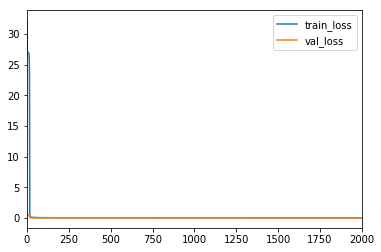

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# loss의 결과를 시각화하세요.
pd.DataFrame(hist).plot()

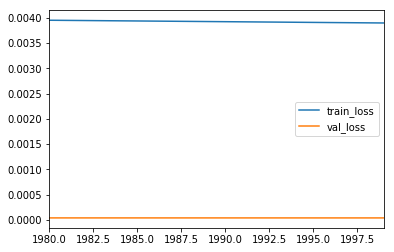

In [15]:
pd.DataFrame(hist)[1980:].plot()